In [1]:
# FUNDMENTAL SETTING
# INTERNAL MODULES
from time import time
import multiprocessing as mp
from multiprocessing import Pool, Process, Queue, Manager

# STANDARD MODULES
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

from scipy import integrate, interpolate
from scipy import stats
import scipy.special as special
from scipy.special import expn, wofz, gamma
from scipy.optimize import curve_fit, minimize

from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score

import emcee
import corner

# LOCAL MODULES


# CONFIGURATION
%config InlineBackend.figure_format='retina'
#%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rc('legend', fontsize=12)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
#plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True

# Midterm
---

In [14]:
# Model 1: Gaussian
def likelihood_gauss(x, mu, sig):
    return 1/(2*np.pi)**0.5/sig * np.exp(-(x-mu)**2/2/sig**2)

# Model 2: Student's t-distribution
def likelihood_stu_t(x, mu, sig, v):
    return gamma((v+1)/2)/gamma(v/2)/sig/(np.pi*v)**0.5 * (1+(x-mu)**2/v/sig**2)**(-(v+1)/2)

## Problem 1

In [2]:
N = 300
mu, sig = 0, 1
sample = np.random.normal(mu, sig, size=(N,N))

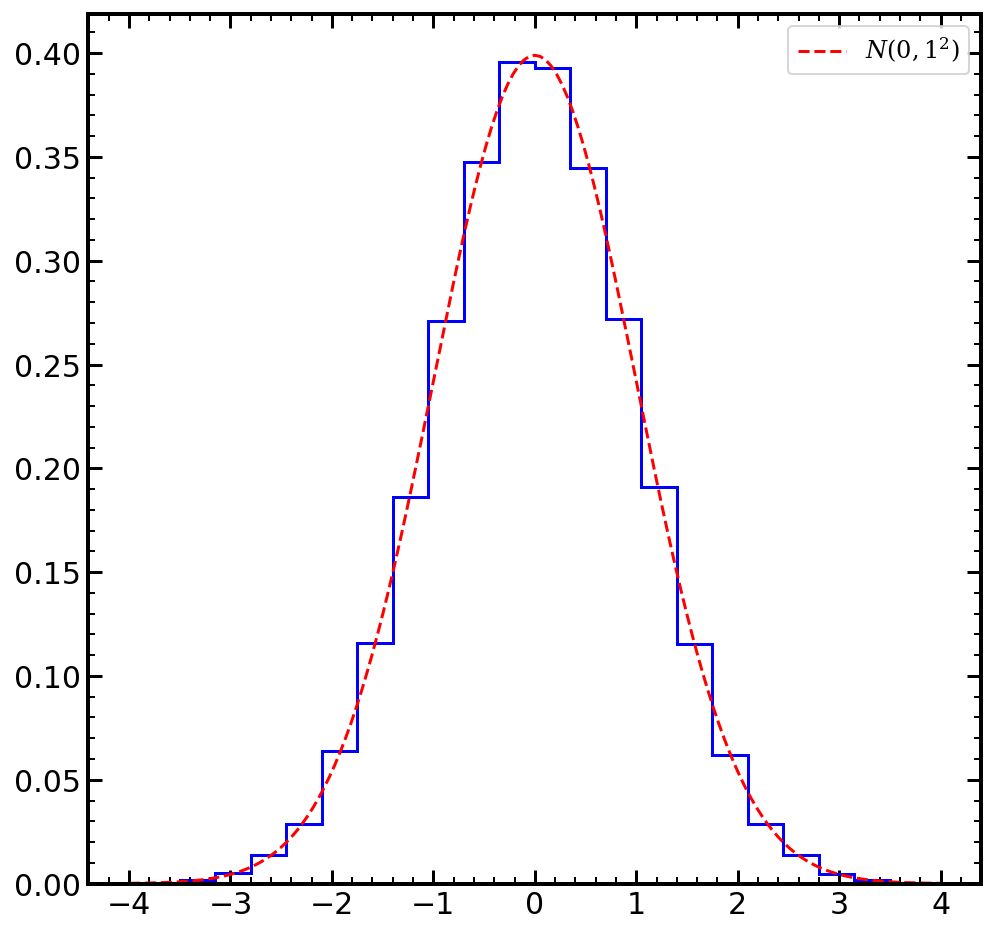

In [5]:
fig = plt.figure(figsize=(8,8))

xs = np.linspace(-4,4,151)
bins = np.linspace(-3.5,3.5,21)
hist_kwargs = {'bins':bins, 'histtype':'step', 'density':True, 'linewidth':1.5}

plt.hist(sample.reshape(-1), **hist_kwargs, color='b')
plt.plot(xs, likelihood_gauss(xs, mu, sig), linestyle='--', color='red', label=rf'$N({mu}, {sig}^2)$')

plt.legend()
plt.show()

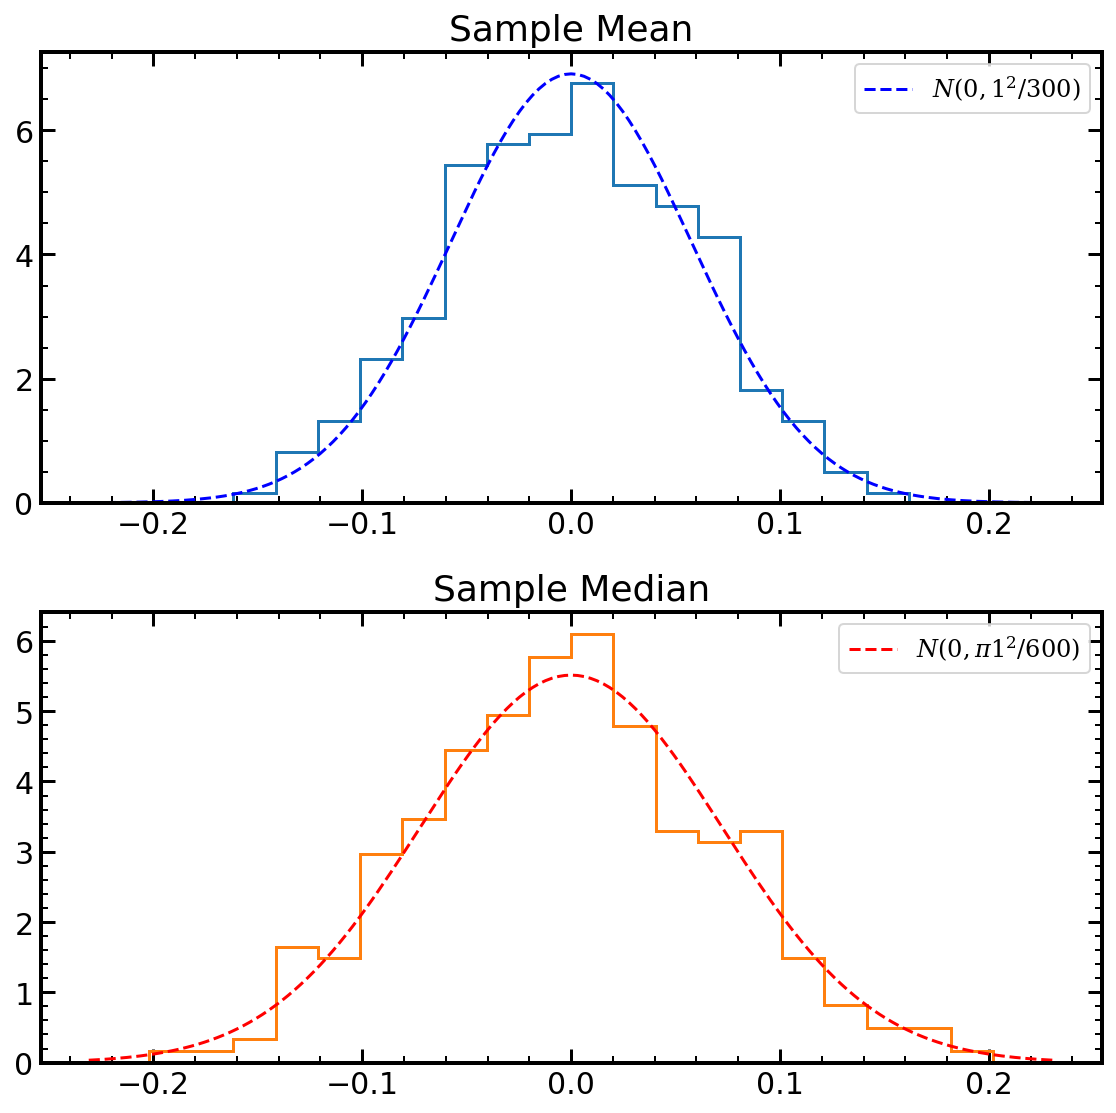

In [8]:
sample_mean = np.mean(sample, axis=-1)
sample_med = np.median(sample, axis=-1)

fig, ax = plt.subplots(2, figsize=(8,8))

xs = np.linspace(-4,4,151)/N**0.5
bins = np.linspace(-3.5,3.5,21)/N**0.5
hist_kwargs = {'bins':bins, 'histtype':'step', 'density':True, 'linewidth':1.5}

ax[0].hist(sample_mean, **hist_kwargs)
ax[0].plot(xs, likelihood_gauss(xs, mu, sig/N**0.5), 
           linestyle='--', color='b', label=rf'$N({mu}, {sig}^2/{N})$')
ax[0].set(title='Sample Mean')
ax[0].legend()

ax[1].hist(sample_med, **hist_kwargs, color='C1')
ax[1].plot(xs, likelihood_gauss(xs, mu, sig*(np.pi/2/N)**0.5), 
           linestyle='--', color='r', label=rf'$N({mu}, \pi{sig}^2/{2*N})$')
ax[1].set(title='Sample Median')
ax[1].legend()

plt.tight_layout()
plt.show()

## Problem 3

In [9]:
def func(x):
    return np.exp(-(500-x)**2/2/(5000+x))/np.sqrt(2*np.pi*(5000+x))

result = integrate.quad(func, 0,5000)
print(result)

(0.9999999999992688, 1.3048483313721023e-11)


## Problem 4

In [10]:
def func(beta, theta):
    if (5*beta*np.cos(theta) + beta*np.sin(theta) - 5) >= 0:
        return np.sin(theta)/2
    else:
        return 0
    
result = integrate.nquad(func, [[0,1],[0, np.pi]])
print(result)

(0.0004984886826646837, 1.4875981063339884e-08)


## Problem 5

In [11]:
# Data from Table 1 of Secker (1992, AJ, 104, 1472)
data = np.array([-1.75, -3.28, -3.86, -3.88, -4.08,
                 -4.30, -4.54, -4.91, -5.20, -5.24,
                 -5.28, -5.52, -5.57, -5.87, -5.89,
                 -5.89, -6.04, -6.07, -6.14, -6.16,
                 -6.20, -6.24, -6.32, -6.41, -6.45,
                 -6.48, -6.49, -6.53, -6.54, -6.66,
                 -6.68, -6.76, -6.80, -6.91, -6.93,
                 -6.95, -6.95, -6.96, -6.97, -7.03,
                 -7.04, -7.08, -7.17, -7.18, -7.19,
                 -7.26, -7.27, -7.31, -7.34, -7.37,
                 -7.37, -7.38, -7.42, -7.43, -7.45, 
                 -7.48, -7.52, -7.55, -7.57, -7.64, 
                 -7.64, -7.65, -7.65, -7.70, -7.77, 
                 -7.77, -7.79, -7.85, -7.85, -7.86, 
                 -7.86, -7.88, -7.97, -7.98, -7.99, 
                 -8.02, -8.04, -8.14, -8.19, -8.20, 
                 -8.23, -8.24, -8.27, -8.29, -8.35, 
                 -8.40, -8.59, -8.60, -8.65, -8.70, 
                 -8.73, -8.80, -8.82, -9.04, -9.08, 
                 -9.24, -9.25, -9.33, -9.34, -10.28])

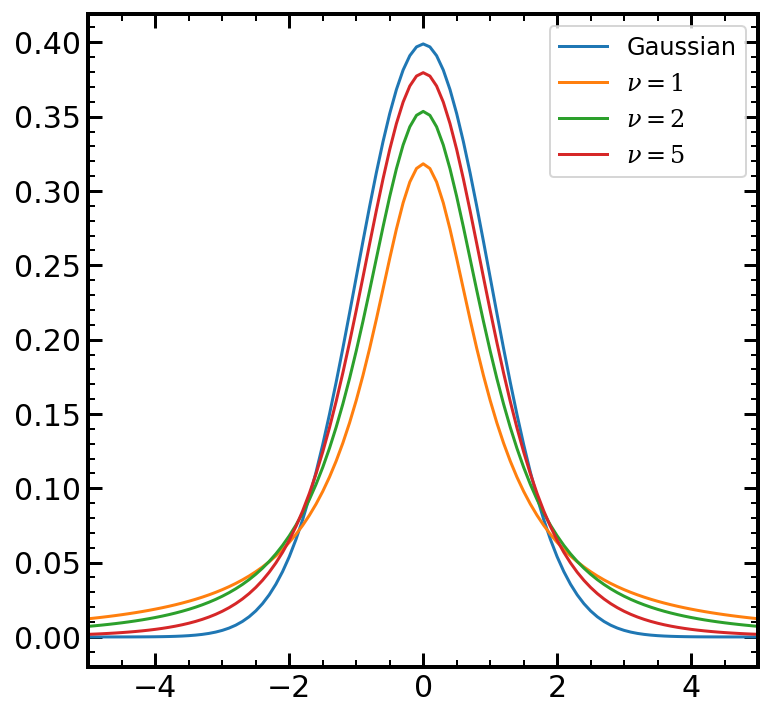

In [15]:
# draw the distributions
x = np.linspace(-5,5,101)
mu = 0
sig = 1
v = [1, 2, 5]

fig = plt.figure(figsize=(6,6))
plt.plot(x, likelihood_gauss(x, mu, sig), label='Gaussian')
plt.plot(x, likelihood_stu_t(x, mu, sig, v[0]), label=r'$\nu = 1$')
plt.plot(x, likelihood_stu_t(x, mu, sig, v[1]), label=r'$\nu = 2$')
plt.plot(x, likelihood_stu_t(x, mu, sig, v[2]), label=r'$\nu = 5$')

plt.xlim(-5,5)
plt.legend()
plt.show()

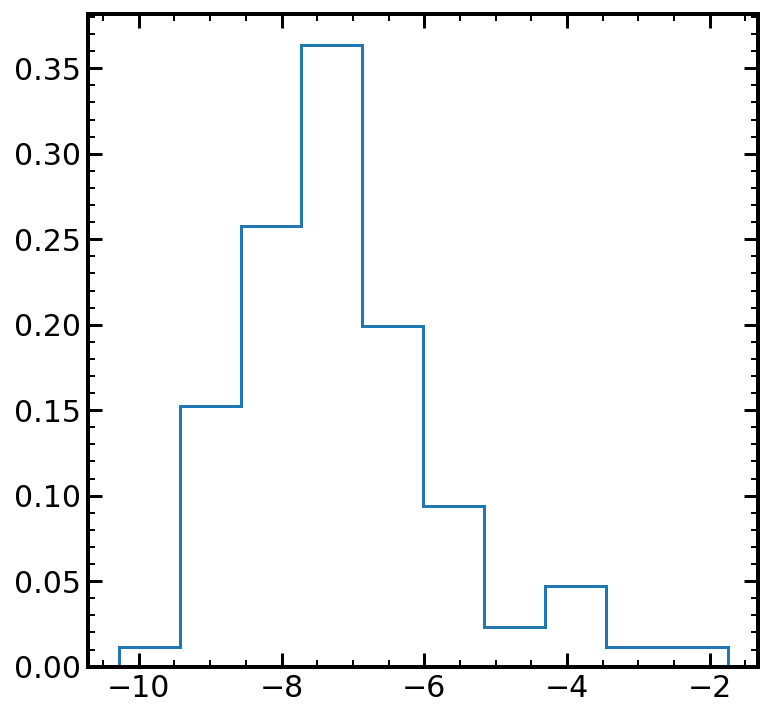

In [16]:
# Data Histogram
fig = plt.figure(figsize=(6,6))

# bins1 = np.linspace(-11,-7,9)
# bins2 = np.linspace(-11,-7,18)
hist_kwargs = {'bins':None, 'histtype':'step', 'density':True, 'stacked':True, 'linewidth':1.5}

plt.hist(data, **hist_kwargs)

plt.show()

In [20]:
# Find the best parameters by minimizing Negative Log Likelihood
def NLL1(p):
    mu, sig = p[0], p[1]
    return -np.sum(np.log(likelihood_gauss(data, mu, sig)))

def NLL2(p):
    mu, sig, v = p[0], p[1], p[2]
    return -np.sum(np.log(likelihood_stu_t(data, mu, sig, v)))

opt1 = minimize(NLL1, x0=[data.mean(), 1.], tol=1e-8)['x']
opt2 = minimize(NLL2, x0=[data.mean(), 1., 2.], tol=1e-8)['x']

print(opt1, opt2)

[-7.1378      1.41224402] [-7.29851912  1.06665878  4.27551527]


In [21]:
# BIC Calculation
BIC1 = 2*NLL1(opt1) + 2*np.log(len(data))
BIC2 = 2*NLL2(opt2) + 3*np.log(len(data))
dBIC = BIC1 - BIC2

print(BIC1, BIC2, dBIC)

362.0340349772451 359.5631313694524 2.4709036077927067


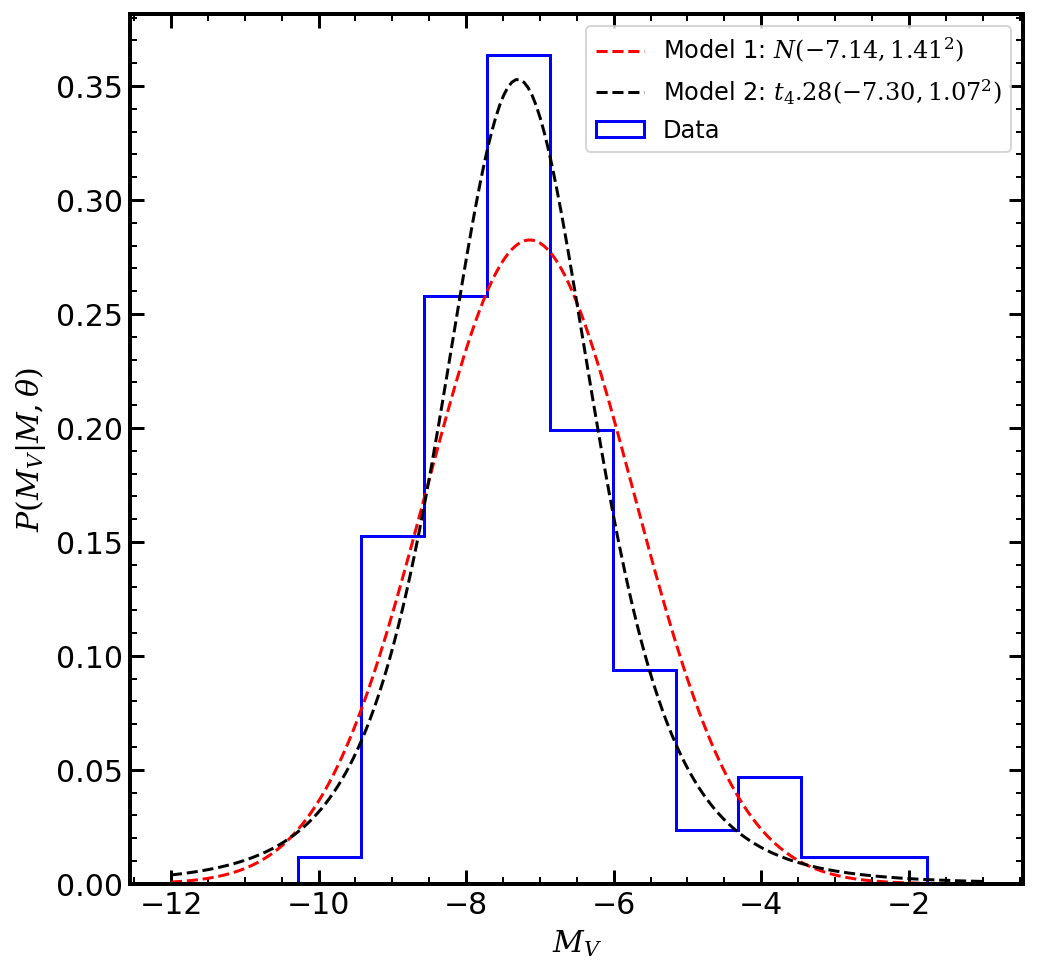

In [23]:
# Data Histogram
fig = plt.figure(figsize=(8,8))

# bins1 = np.linspace(-11,-7,9)
# bins2 = np.linspace(-11,-7,18)
hist_kwargs = {'bins':None, 'histtype':'step', 'density':True, 'stacked':True, 'linewidth':1.5}

plt.hist(data, **hist_kwargs, color='blue', label='Data')

x = np.linspace(-12, -1, 201)
plt.plot(x, likelihood_gauss(x, *opt1), linestyle='--', color='red', 
         label=rf'Model 1: $N({opt1[0]:.2f}, {opt1[1]:.2f}^2)$')
plt.plot(x, likelihood_stu_t(x, *opt2), linestyle='--', color='black', 
         label=rf'Model 2: $t_{opt2[2]:.2f}({opt2[0]:.2f}, {opt2[1]:.2f}^2)$')

plt.xlabel(r'$M_V$')
plt.ylabel(r'$P(M_V|M, \theta)$')

plt.legend()
plt.savefig('midexam_5.pdf', dpi=300)
plt.show()

# Homework 1
---

## 1. Principal Component Analysis
Table 6 of AMI Consortium (2012, MNRAS, 425, 162) offers the total mass ($M^T_{200}$), gas mass ($M^{gas}_{200}$), X-ray temperature ($T_{AMI}$, the Sunyaev-Zel'dovich effect parameter ($Y_{200}$) of the galaxy clusters.

In [8]:
df = pd.read_csv('statastro_hwprob1.csv')
df

Name  M_T_r200  M_T_r500  M_g_r200  M_g_r500  r200  r500  T_AMI  \
0           A586       5.1       2.1       4.3       2.6   1.2   6.6    5.2   
1           A611       4.0       2.0       3.5       2.8   1.1   6.3    4.5   
2           A621       4.8       1.4       4.1       1.5   1.2   5.3    5.0   
3           A773       3.6       1.7       3.1       2.1   1.1   6.0    4.1   
4           A781       4.1       2.0       3.6       2.9   1.1   6.3    4.5   
5           A990       2.0       1.1       1.8       1.6   0.9   5.5    2.8   
6          A1413       4.0       1.9       3.5       2.7   1.1   6.6    4.4   
7          A1423       2.2       1.1       1.9       1.5   0.9   5.3    3.0   
8         A1758a       4.1       2.5       3.6       3.4   1.1   6.8    4.5   
9         A1758b       4.4       2.2       3.7       2.2   1.1   6.4    4.6   
10         A2009       4.6       2.0       3.9       2.4   1.2   6.5    4.8   
11         A2111       4.2       1.8       3.6       2.5   1.1   6.2    4.6   
12         A2146       5.0       2.7       4.4       3.7   1.2   7.1    5.2   
13         A2218       6.1       2.7       5.4       4.3   1.3   7.3    5.9   
14  RXJ0142+2131       3.7       1.7       3.1       2.1   1.0   5.9    4.2   
15  RXJ1720+2638       2.0       1.2       1.7       1.6   0.9   5.6    2.8   

    Y_r200  Y_r500  
0      3.6     2.7  
1      2.2     2.1  
2      3.1     1.9  
3      1.9     1.6  
4      2.3     2.2  
5      0.7     0.7  
6      2.2     2.1  
7      0.9     0.8  
8      2.3     2.3  
9      2.7     1.6  
10     2.8     2.2  
11     2.4     2.2  
12     3.2     3.1  
13     4.5     4.4  
14     2.0     1.5  
15     0.7     0.7

In [9]:
data = df[['M_T_r200', 'M_g_r200', 'T_AMI', 'Y_r200']].to_numpy()

In [10]:
pca = PCA(n_components=4)
pca.fit(data)

PCA(n_components=4)

In [11]:
pca.components_

array([[ 0.56419566,  0.49003404,  0.43132506,  0.50547858],
       [-0.18915354, -0.24021525, -0.45793192,  0.83475501],
       [-0.35540484,  0.83727107, -0.41045163, -0.06476117],
       [ 0.72082702, -0.03377017, -0.66014128, -0.20852213]])

In [12]:
pca_data = []
for vector in pca.components_:
    pca_data.append(data@vector)

In [13]:
pca_data

[array([ 9.04715742,  7.02491741,  8.44088761,  6.27905193,  7.18088824,
         3.57199776,  6.9817849 ,  3.92120102,  7.18088824,  7.64447428,
         7.99213309,  7.33098817,  8.83754982, 10.90724878,  6.42915186,
         3.52299436]),
 array([-1.37373663, -1.82160019, -1.59473863, -1.71710641, -1.78106157,
        -1.50857542, -1.775807  , -1.49506304, -1.78106157, -1.57372035,
        -1.66770499, -1.76229462, -1.7127448 , -1.39639979, -1.69833945,
        -1.4845539 ]),
 array([-0.57978776, -0.48067752, -0.52614961, -0.48981501, -0.43896701,
        -0.39831914, -0.43963236, -0.48071556, -0.43896701, -0.52881099,
        -0.52100418, -0.52202878, -0.4346157 , -0.35979562, -0.57287677,
        -0.48204624]),
 array([-0.65240824, -0.66427196, -0.625613  , -0.61248154, -0.61641848,
        -0.61349334, -0.59825783, -0.64643763, -0.61641848, -0.55297037,
        -0.56843947, -0.63120212, -0.64445911, -0.61849722, -0.62726518,
        -0.61011632])]

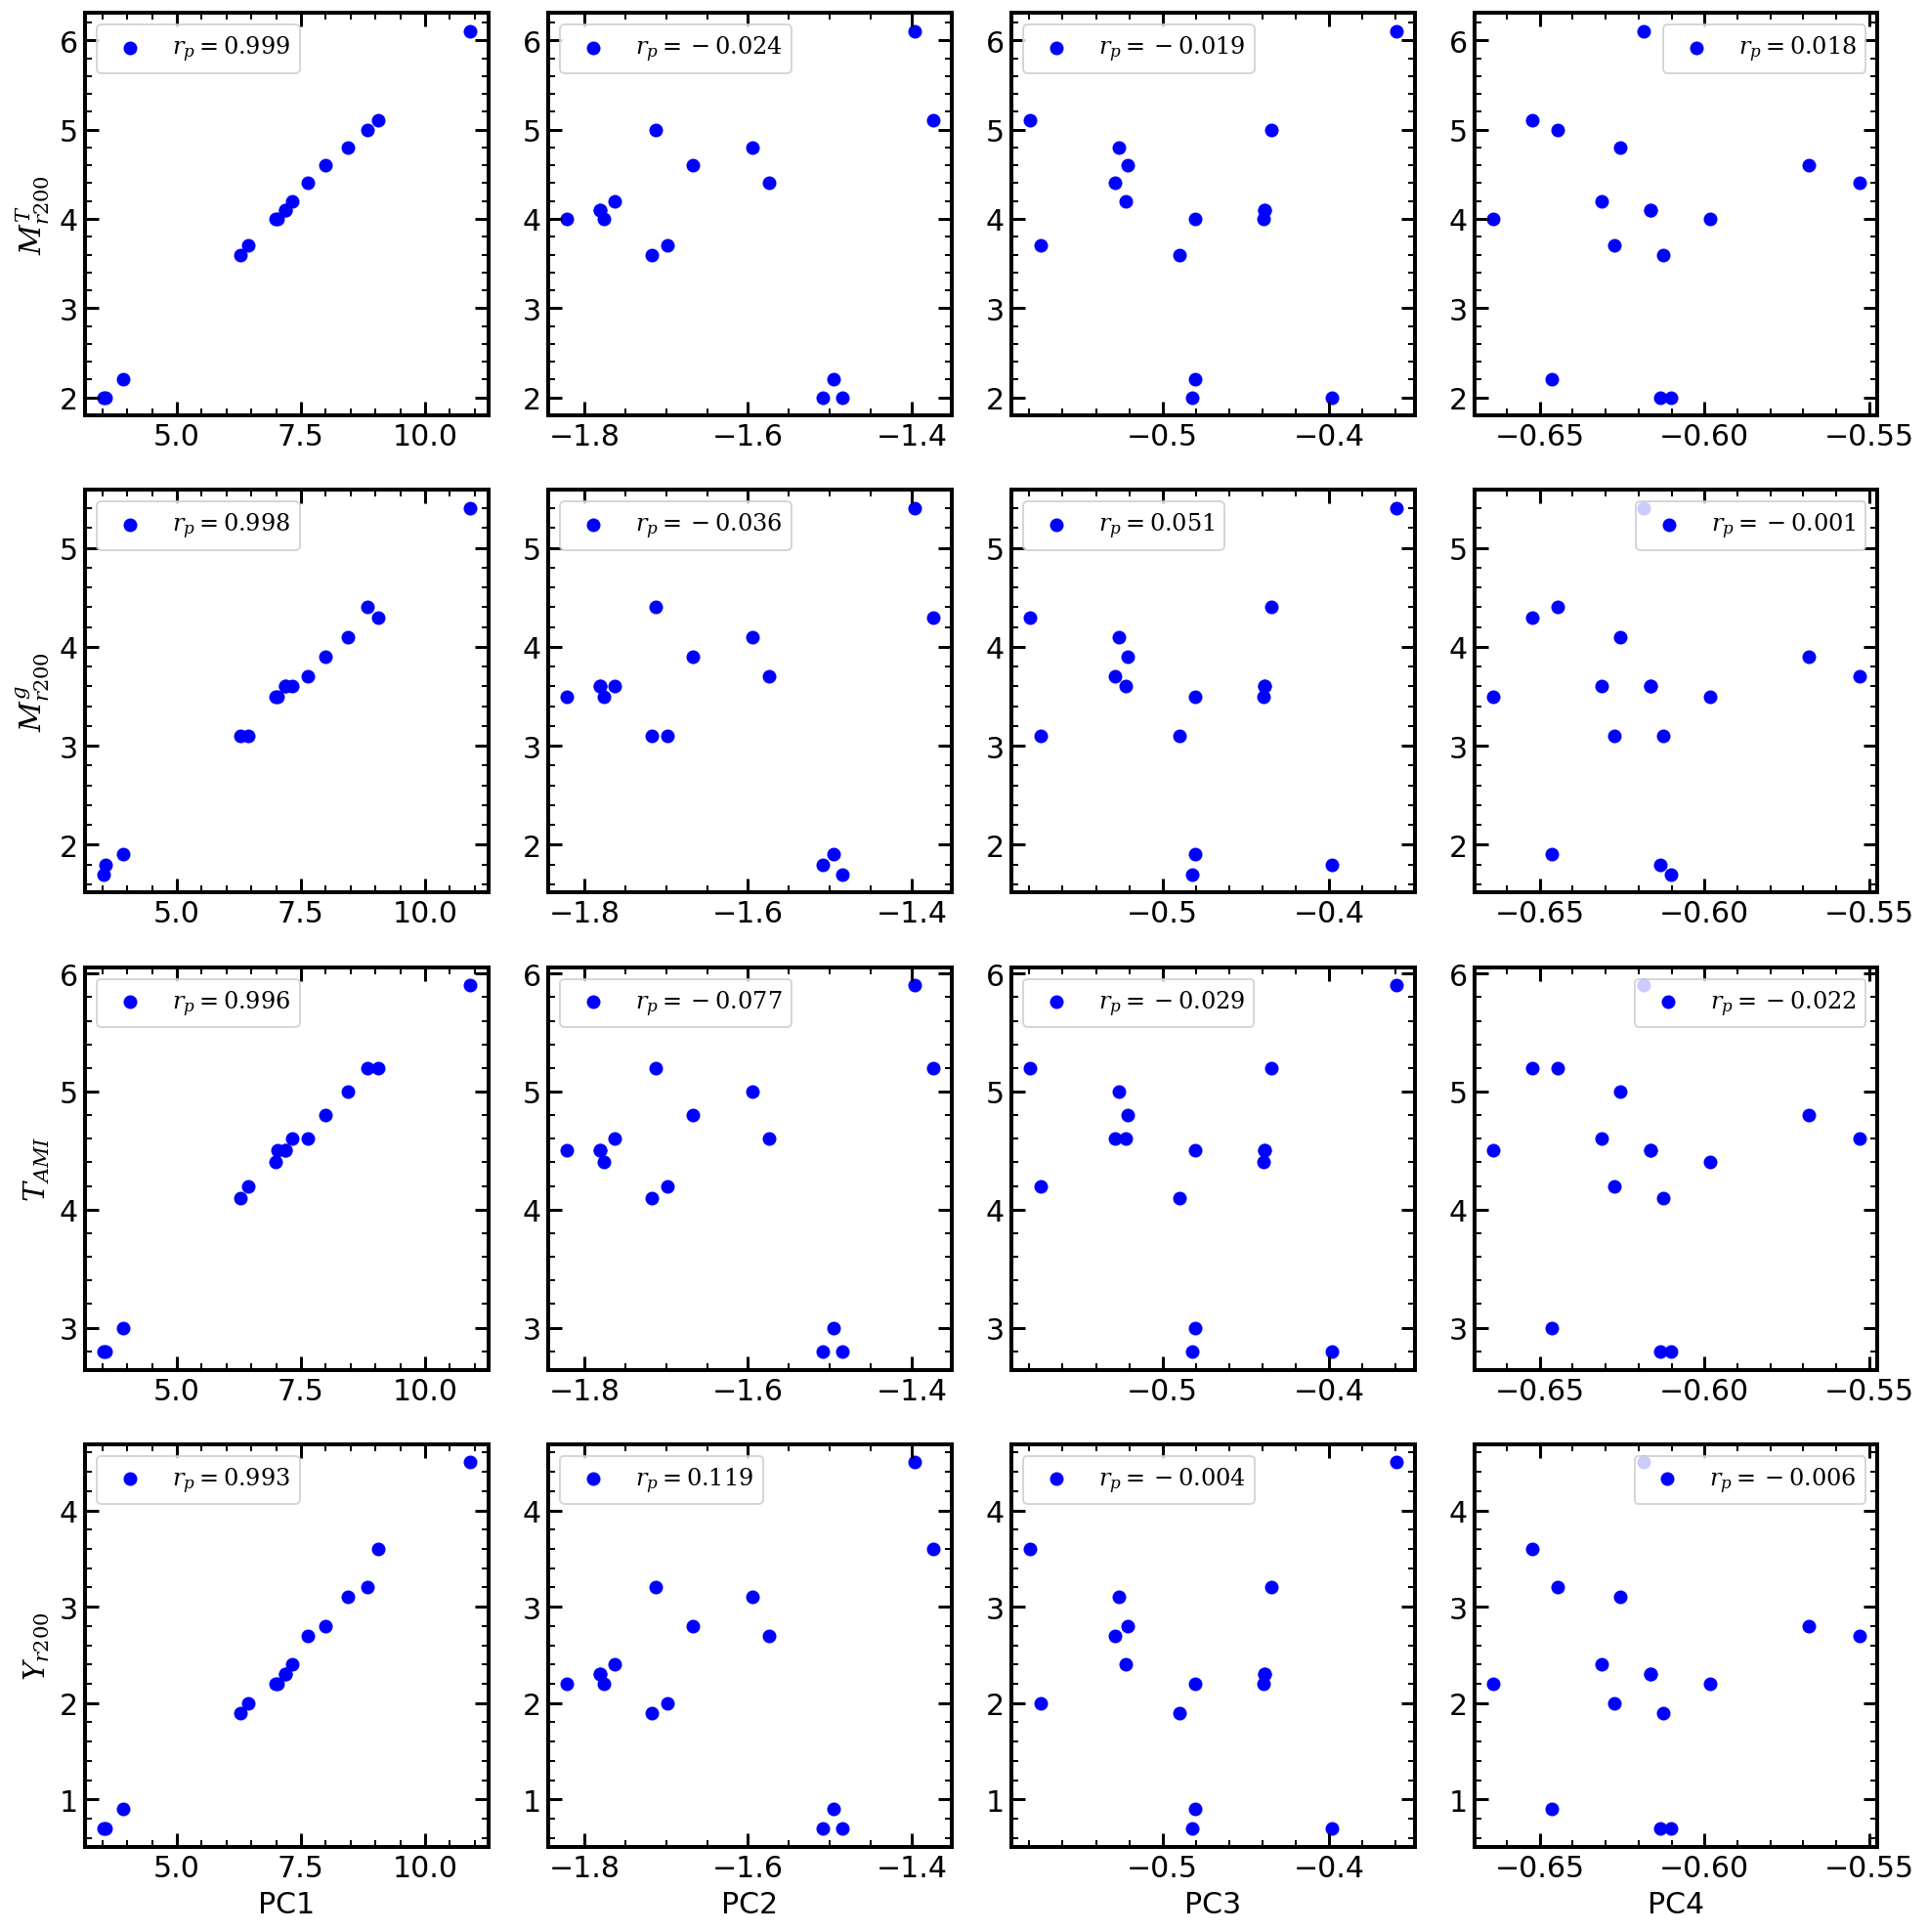

In [14]:
fig, ax = plt.subplots(4,4, figsize=(14,14))

label_data = ['$M^T_{r200}$', '$M^g_{r200}$', '$T_{AMI}$', '$Y_{r200}$']

for i in range(4):
    for j in range(4):
        rp = np.corrcoef(pca_data[j], data[:,i])[0,1]
        ax[i,j].scatter(pca_data[j], data[:,i], color='blue', label=rf'$r_p = {rp:.3f}$')
        ax[i,j].legend()
        if j==0:
            ax[i,j].set(ylabel=rf'{label_data[i]}') 
        if i==3:
            ax[i,j].set(xlabel=f'PC{j+1}')
        
plt.tight_layout()
plt.show()

In [16]:
methods = ['pearson', 'spearman', 'kendall']

corr1 = [df[['M_T_r200', 'M_g_r200']].corr(method=methods[i])['M_T_r200']['M_g_r200'] for i in range(3)]
corr2 = [df[['T_AMI', 'Y_r200']].corr(method=methods[i])['T_AMI']['Y_r200'] for i in range(3)]
corr3 = [df[['M_g_r200', 'T_AMI']].corr(method=methods[i])['M_g_r200']['T_AMI'] for i in range(3)]

In [21]:
pvalue1 = [stats.pearsonr(df['M_T_r200'], df['M_g_r200'])[1], stats.spearmanr(df['M_T_r200'], df['M_g_r200'])[1], stats.kendalltau(df['M_T_r200'], df['M_g_r200'])[1]]
pvalue2 = [stats.pearsonr(df['T_AMI'], df['Y_r200'])[1], stats.spearmanr(df['T_AMI'], df['Y_r200'])[1], stats.kendalltau(df['T_AMI'], df['Y_r200'])[1]] 
pvalue3 = [stats.pearsonr(df['M_g_r200'], df['T_AMI'])[1], stats.spearmanr(df['M_g_r200'], df['T_AMI'])[1], stats.kendalltau(df['M_g_r200'], df['T_AMI'])[1]] 

In [27]:
text1 = rf'$r_p = {corr1[0]:.3f}$, p-val = {pvalue1[0]:.1e}{nl}$r_s = {corr1[1]:.3f}$, p-val = {pvalue1[1]:.1e}{nl}$r_\tau = {corr1[2]:.3f}$, p-val = {pvalue1[2]:.1e}'
text2 = rf'$r_p = {corr2[0]:.3f}$, p-val = {pvalue2[0]:.1e}{nl}$r_s = {corr2[1]:.3f}$, p-val = {pvalue2[1]:.1e}{nl}$r_\tau = {corr2[2]:.3f}$, p-val = {pvalue2[2]:.1e}'
text3 = rf'$r_p = {corr3[0]:.3f}$, p-val = {pvalue3[0]:.1e}{nl}$r_s = {corr3[1]:.3f}$, p-val = {pvalue3[1]:.1e}{nl}$r_\tau = {corr3[2]:.3f}$, p-val = {pvalue3[2]:.1e}'

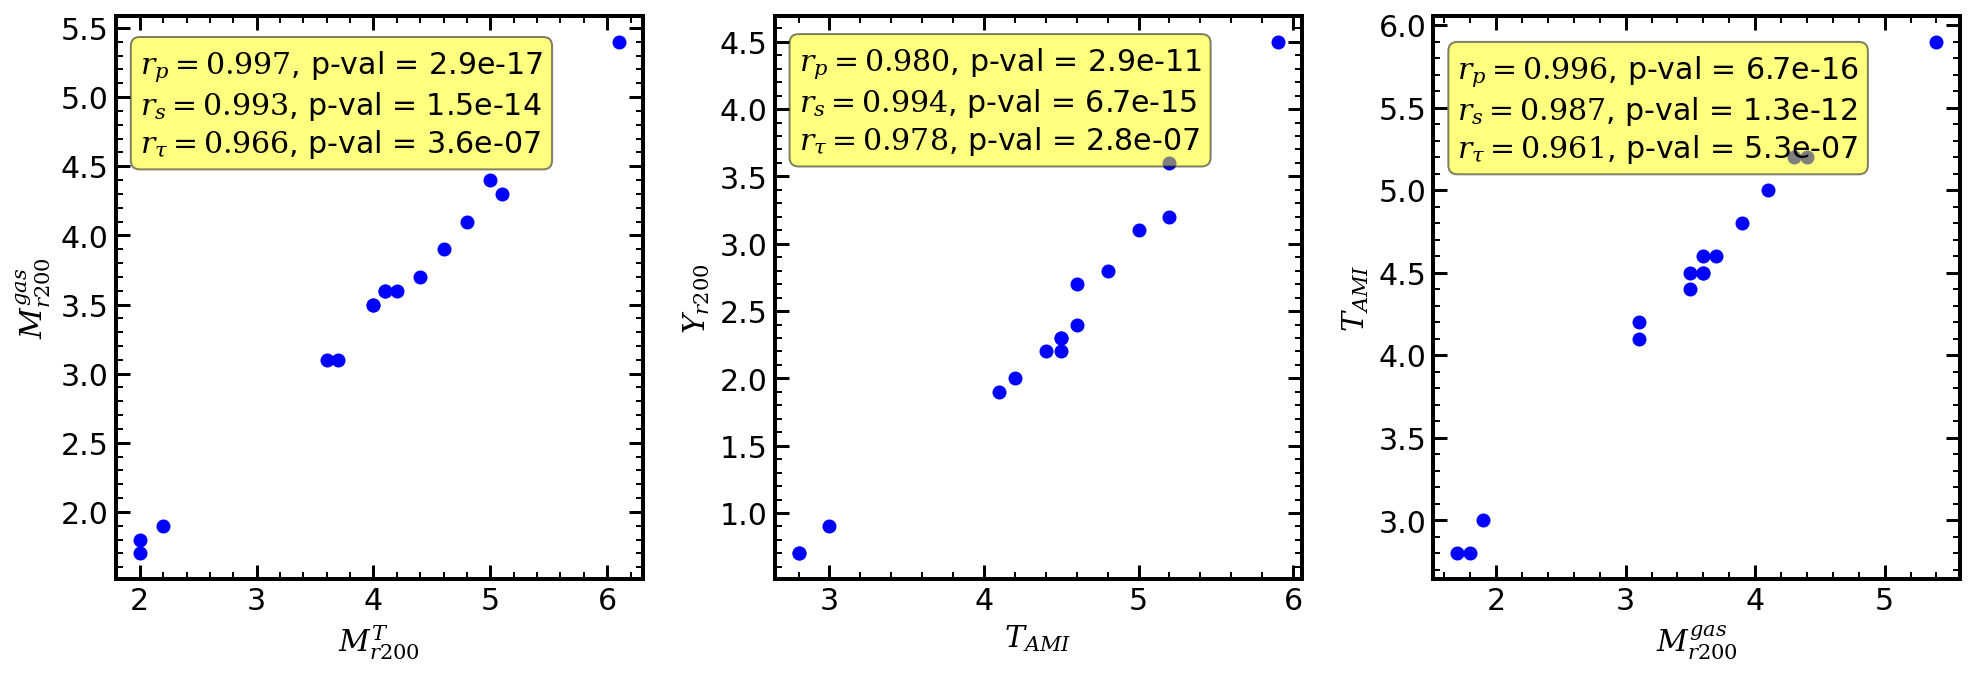

In [34]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

nl = '\n'

ax[0].scatter(data[:,0], data[:,1], color='blue')
ax[0].set(xlabel=r'$M^T_{r200}$', ylabel=r'$M^{gas}_{r200}$')
ax[0].text(2, 4.6, text1, bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})

ax[1].scatter(data[:,2], data[:,3], color='blue')
ax[1].set(xlabel=r'$T_{AMI}$', ylabel=r'$Y_{r200}$')
ax[1].text(2.8, 3.7, text2, bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})

ax[2].scatter(data[:,1], data[:,2], color='blue')
ax[2].set(xlabel=r'$M^{gas}_{r200}$', ylabel=r'$T_{AMI}$')
ax[2].text(1.7, 5.2, text3, bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})

plt.tight_layout()
plt.show()

In [40]:
def calc_mutual_info(x, y, binning):
    N_xy = np.zeros((binning,binning))
    bin_x = np.linspace(min(x), max(x), binning+1)
    bin_y = np.linspace(min(y), max(y), binning+1)

    for xx, yy in zip(x,y):
        for i in range(binning):
            if xx >= bin_x[i] and xx < bin_x[i+1]: 
                break
        for j in range(binning):
            if yy >= bin_y[j] and yy < bin_y[j+1]:
                break
        N_xy[i,j] += 1

    # plt.imshow(N_xy)
    # plt.show()
    
    mutual_info = 0
    N = N_xy.sum()
    if N == len(data):
        for i in range(binning):
            for j in range(binning):
                N_x = N_xy[i,:].sum()
                N_y = N_xy[:,j].sum()
                if N_xy[i,j] != 0:
                    mutual_info += N_xy[i,j]/N * np.log(N_xy[i,j]*N/N_x/N_y)
    entropy_x = 0
    for i in range(binning):
        N_x = N_xy[i,:].sum()
        if N_x != 0:
            entropy_x += - N_x/N * np.log(N_x/N)
    entropy_y = 0
    for j in range(binning):
        N_y = N_xy[:,j].sum()
        if N_y != 0:
            entropy_y += - N_y/N * np.log(N_y/N)
                    
    return mutual_info, entropy_x, entropy_y

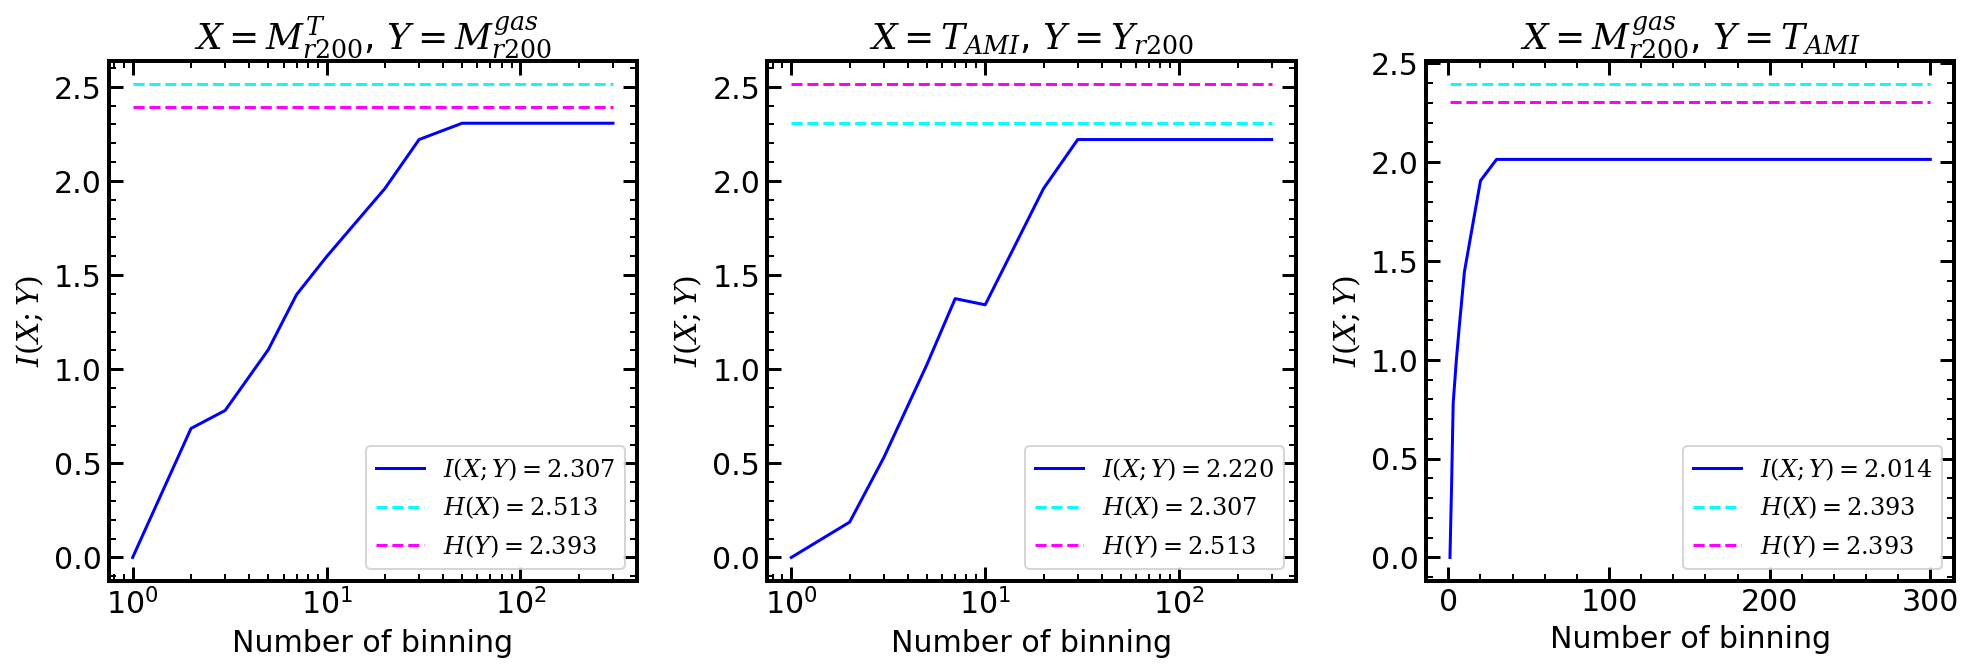

In [47]:
binnings = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 200, 300]
mutual_infos1 = []
mutual_infos2 = []
mutual_infos3 = []

for binning in binnings:
    mutual_infos1.append(calc_mutual_info(data[:,0], data[:,1], binning))
    mutual_infos2.append(calc_mutual_info(data[:,2], data[:,3], binning))
    mutual_infos3.append(calc_mutual_info(data[:,1], data[:,2], binning))
    
mutual_infos1 = np.array(mutual_infos1)
mutual_infos2 = np.array(mutual_infos2)
mutual_infos3 = np.array(mutual_infos3)

fig, ax = plt.subplots(1,3, figsize=(14,5))

nl = '\n'

ax[0].plot(binnings, mutual_infos1[:,0], color='blue', 
           label=rf'$I(X;Y)= {mutual_infos1[-1,0]:.3f}$')
ax[0].plot(binnings, mutual_infos1[-1,1]*np.ones(len(binnings)), ls='--', color='cyan',
          label=rf'$H(X) = {mutual_infos1[-1,1]:.3f}$')
ax[0].plot(binnings, mutual_infos1[-1,2]*np.ones(len(binnings)), ls='--', color='magenta',
          label=rf'$H(Y) = {mutual_infos1[-1,2]:.3f}$')
ax[0].set(xlabel='Number of binning', ylabel=r'$I(X;Y)$', xscale='log',
          title=r'$X = M^T_{r200}$, $Y = M^{gas}_{r200}$')
ax[0].legend()

ax[1].plot(binnings, mutual_infos2[:,0], color='blue', 
           label=f'$I(X;Y)= {mutual_infos2[-1,0]:.3f}$')
ax[1].plot(binnings, mutual_infos2[-1,1]*np.ones(len(binnings)), ls='--', color='cyan',
          label=rf'$H(X) = {mutual_infos2[-1,1]:.3f}$')
ax[1].plot(binnings, mutual_infos2[-1,2]*np.ones(len(binnings)), ls='--', color='magenta',
          label=rf'$H(Y) = {mutual_infos2[-1,2]:.3f}$')
ax[1].set(xlabel='Number of binning', ylabel=r'$I(X;Y)$', xscale='log',
          title=r'$X = T_{AMI}$, $Y = Y_{r200}$')
ax[1].legend()

ax[2].plot(binnings, mutual_infos3[:,0], color='blue', 
           label=f'$I(X;Y)= {mutual_infos3[-1,0]:.3f}$')
ax[2].plot(binnings, mutual_infos3[-1,1]*np.ones(len(binnings)), ls='--', color='cyan',
          label=rf'$H(X) = {mutual_infos3[-1,1]:.3f}$')
ax[2].plot(binnings, mutual_infos3[-1,2]*np.ones(len(binnings)), ls='--', color='magenta',
          label=rf'$H(Y) = {mutual_infos1[-1,2]:.3f}$')
ax[2].set(xlabel='Number of binning', ylabel=r'$I(X;Y)$', 
          title=r'$X = M^{gas}_{r200}$, $Y = T_{AMI}$')
ax[2].legend()

plt.tight_layout()
plt.show()

## 2. $\chi^2$ contour and MCMC

In [22]:
df = pd.read_csv('statastro_hwprob2.csv')
df

L     M  M_err
0    3.53  1.23   0.19
1    5.67  2.20   0.33
2    2.00  2.23   0.30
3    0.48  0.44   0.10
4    3.80  2.64   0.71
5    0.39  0.55   0.07
6    7.32  5.07   0.75
7   14.90  4.52   0.67
8    2.46  1.37   0.22
9    5.40  3.55   0.50
10   0.49  0.44   0.10
11   0.94  0.94   0.18
12   2.16  2.01   0.49
13   4.79  2.30   0.42
14   4.14  3.51   0.54
15   6.40  2.03   0.26
16  10.54  3.94   0.63
17   1.57  0.69   0.13
18   1.33  0.94   0.17
19  13.45  6.80   0.84
20   1.70  2.28   0.45
21   2.48  1.26   0.16
22   5.25  3.25   0.41
23   1.18  0.64   0.11
24   0.60  0.71   0.11
25   1.18  0.90   0.13
26   4.56  1.76   0.32
27   3.40  1.98   0.37
28   5.21  3.76   0.51
29   1.23  0.95   0.15
30   1.72  2.01   0.35
31   2.09  2.96   0.54
32   0.85  0.69   0.13
33   3.98  2.97   0.39
34   1.90  2.12   0.28
35   4.87  2.82   0.48
36   6.02  5.47   0.74
37   1.28  0.67   0.13
38   1.80  0.96   0.18
39   3.39  1.32   0.19
40   1.83  0.88   0.16
41   0.27  0.28   0.04
42   0.16  0.13   0.04
43   0.16  0.17   0.02
44   2.13  0.63   0.11

In [4]:
df.corr(method='pearson')

L         M     M_err
L      1.000000  0.841317  0.778425
M      0.841317  1.000000  0.948962
M_err  0.778425  0.948962  1.000000

In [5]:
def posterior(x):
    N = 45
    r = df.corr(method='pearson')['M']['L']
    p = lambda x: (1-x**2)**(N/2-0.5) / (1-x*r)**(N-1.5) * (1 + (1+r*x)/8/(N-0.5))
    c = integrate.quad(p, -1, 1)[0]
    
    return  p(x)/c

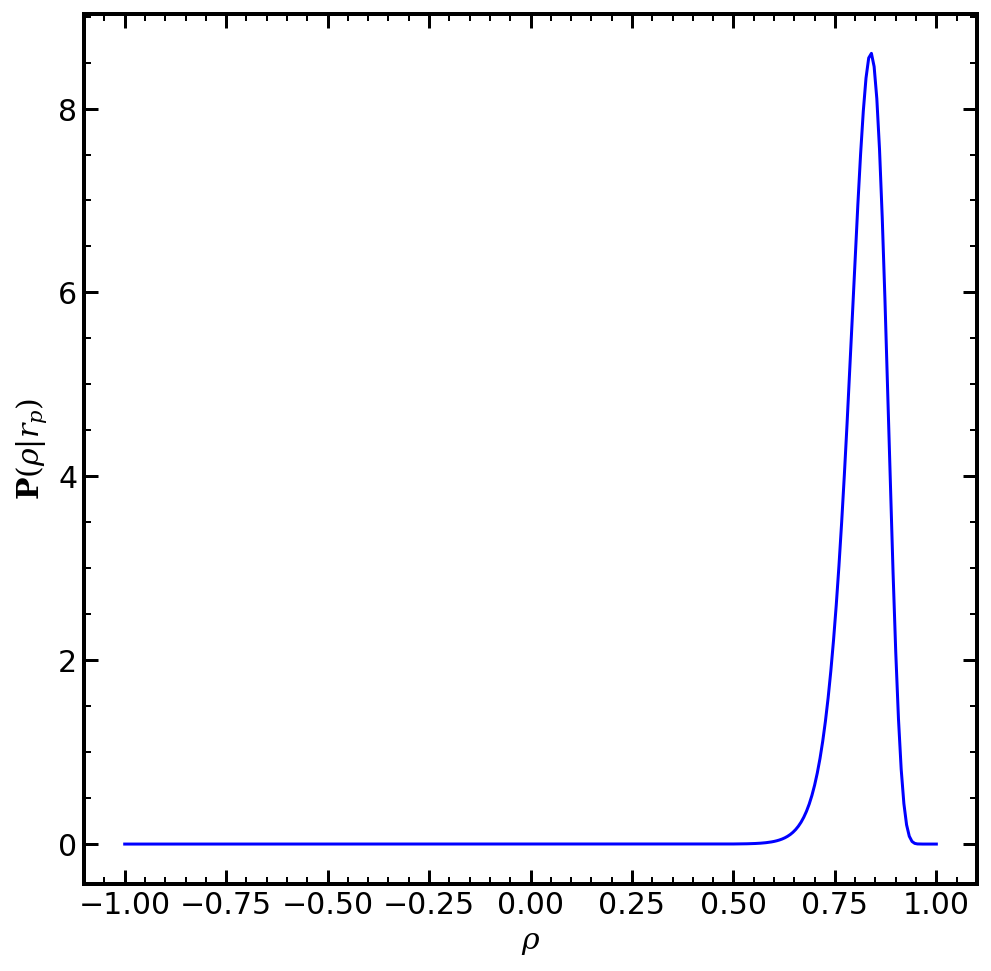

In [36]:
x = np.linspace(-1,1, 301)
y = [posterior(xx)  for xx in x]
fig = plt.figure(figsize=(8,8))

plt.plot(x, y, color='blue')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathbf{P}(\rho|r_p)$')

plt.show()

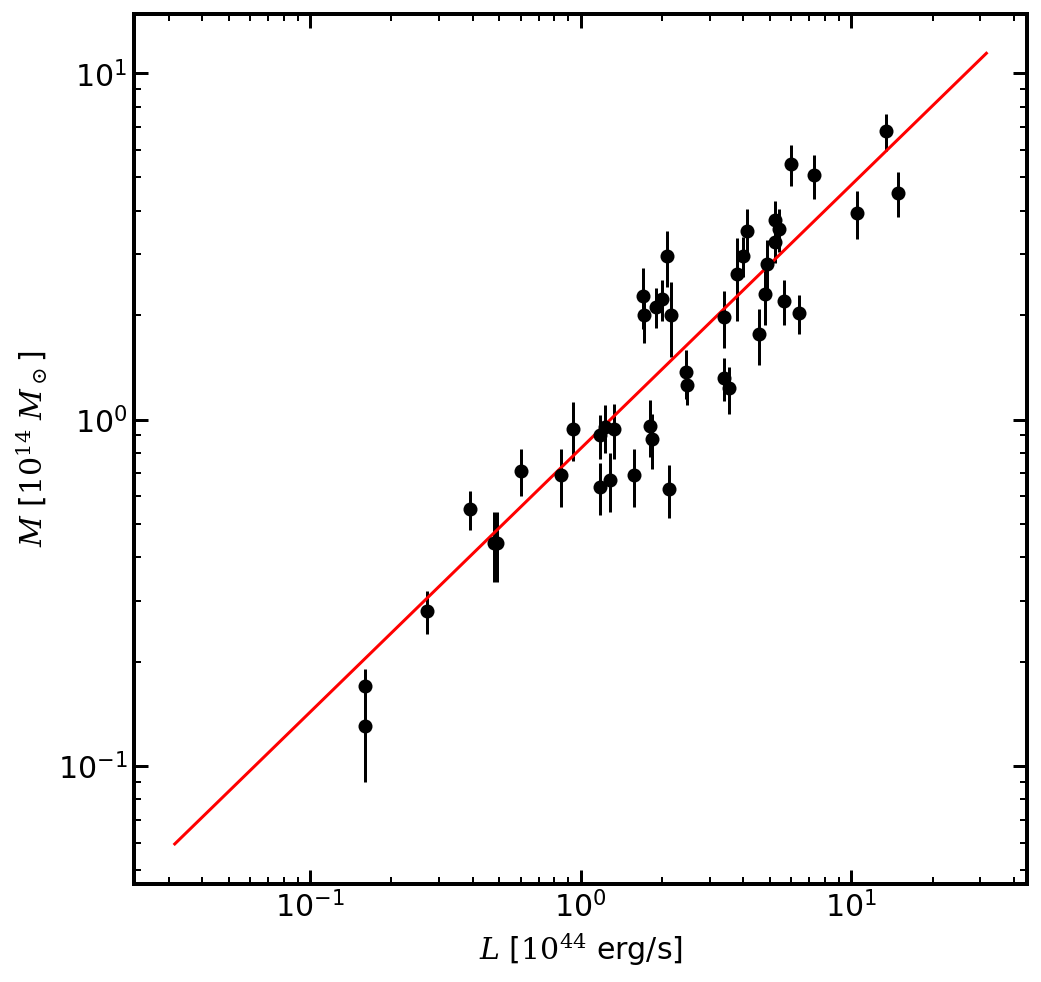

In [57]:
x = np.logspace(-1.5,1.5,51)
y = 10**(0.761 * np.log10(x) - 0.084)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.errorbar(df['L'], df['M'], df['M_err'], color='black', ls='', marker='o')
ax.plot(x,y, color='red')
ax.set(xscale='log', yscale='log', xlabel=r'$L$ [$10^{44}$ erg/s]', ylabel=r'$M$ [$10^{14}$ $M_\odot$]')

plt.show()

In [99]:
np.log10(df['L']).sum()/len(df)

0.3245832280917439

In [46]:
def model1_chi2(a, b):
    result = 0
    for data in df.iloc:
        result += (data['M'] - b * data['L']**a)**2 / data['M_err']**2
    return result

def model2_chi2(a, b):
    result = 0
    for data in df.iloc:
        result += (np.log10(data['M']) - a*np.log10(data['L'])-b)**2 / (data['M_err']/data['M']/np.log(10))**2
    return result

def model3_chi2(a, b):
    result = 0
    mean_logL = np.log10(df['L']).sum()/len(df)
    for data in df.iloc:
        result += (np.log10(data['M']) - a*(np.log10(data['L'])-mean_logL)-b)**2 / (data['M_err']/data['M']/np.log(10))**2
    return result

In [99]:
N = 151
chi_matrix1 = np.zeros((N,N))
chi_matrix2 = np.zeros((N,N))
minval1 = np.inf
minval2 = np.inf

a_space = np.linspace(0.6, 0.9, N)
b_space1 = np.linspace(-0.2, 0.02, N)
b_space2 = np.linspace(0.05, 0.27, N)

for i, a in enumerate(a_space):
    for j, b in enumerate(b_space1):
        chi_matrix1[i,j] = model2_chi2(a, b)
        
        if chi_matrix1[i,j] < minval1:
            minval1 = chi_matrix1[i,j]
            pos1 = (a, b)
    
    for j, b in enumerate(b_space2):
        chi_matrix2[i,j] = model3_chi2(a, b)
        
        if chi_matrix2[i,j] < minval2:
            minval2 = chi_matrix2[i,j]
            pos2 = (a, b)

In [100]:
# model3
print(minval1, pos1)
print(minval2, pos2)

219.07834696773048 (0.762, -0.08853333333333334)
219.0771724104857 (0.762, 0.15853333333333336)


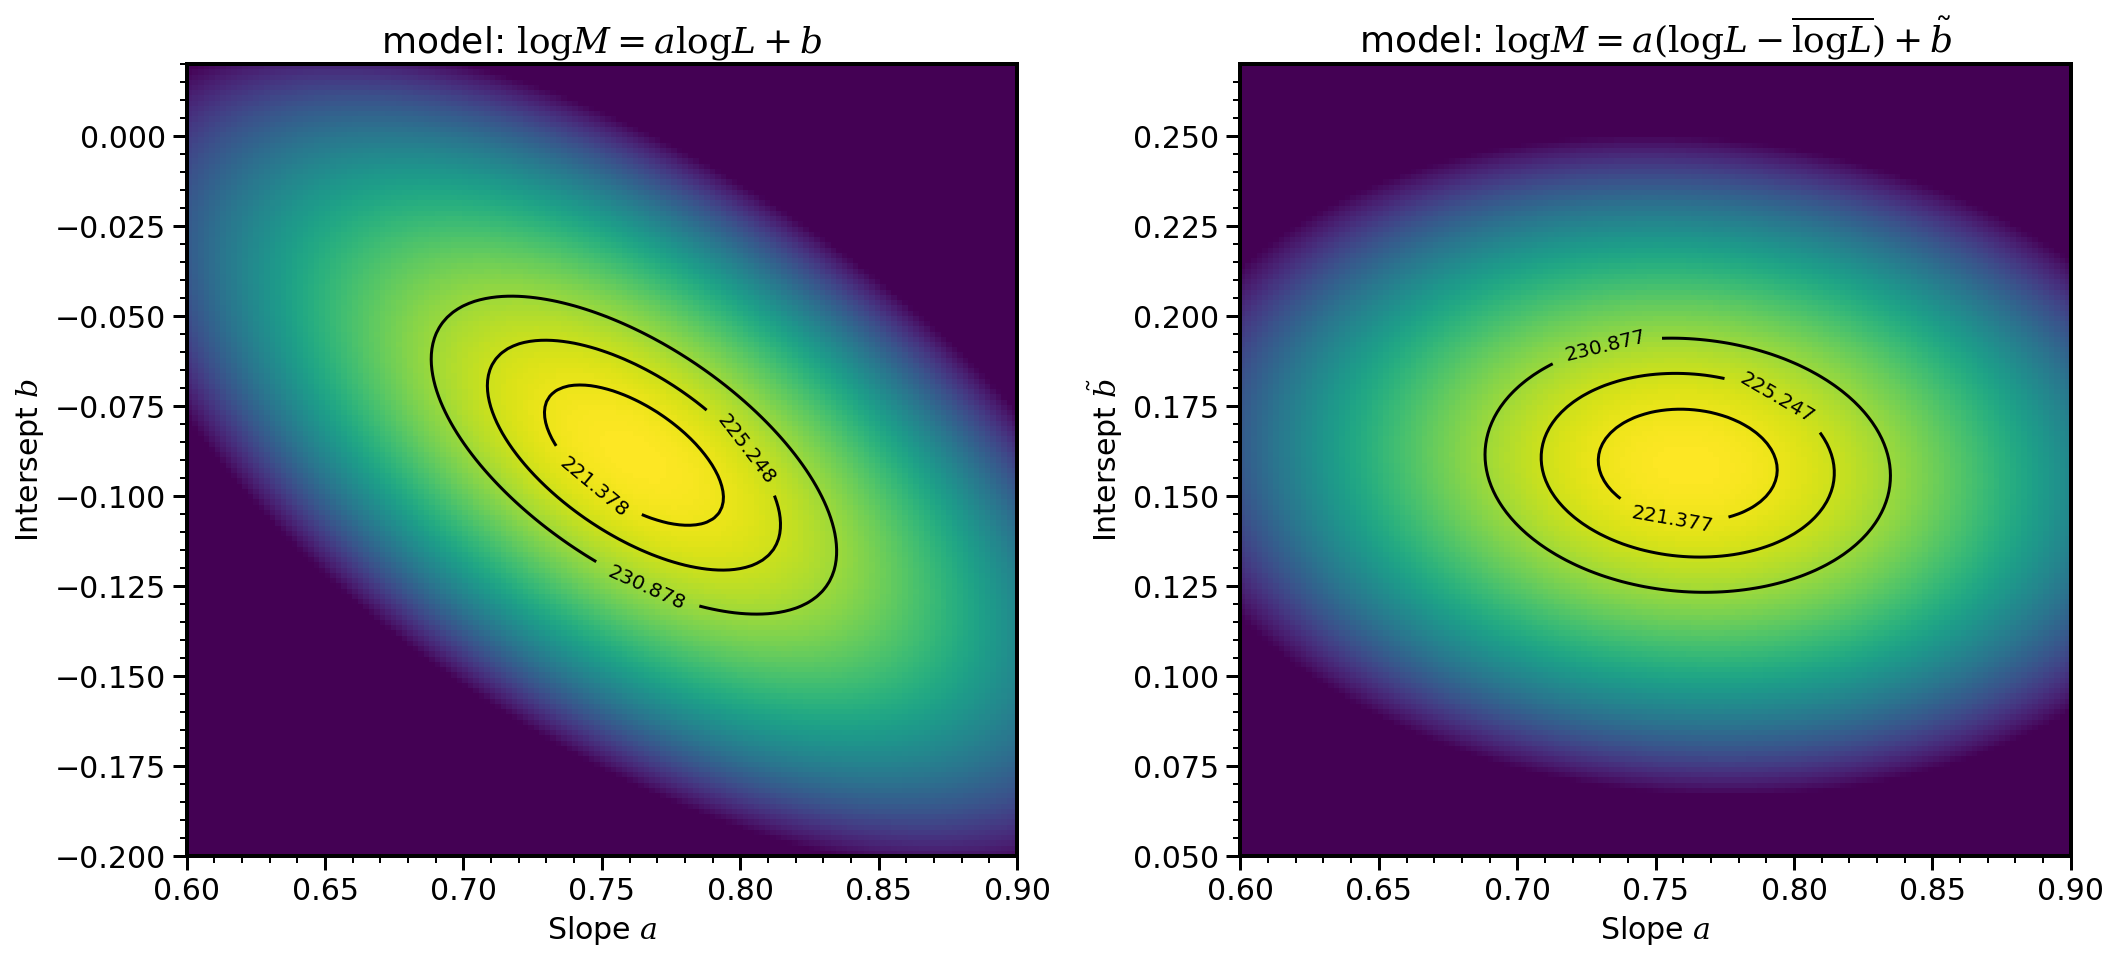

In [120]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

extent1 = np.array([min(a_space), max(a_space), min(b_space1), max(b_space1)])
extent2 = np.array([min(a_space), max(a_space), min(b_space2), max(b_space2)])

ax[0].imshow(chi_matrix1.T, vmax=3e2, cmap='viridis_r', origin='lower', interpolation='nearest', extent=extent1, aspect='auto')
ax[0].set(xlabel=r'Slope $a$', ylabel=r'Intersept $b$', title=r'model: $\log M = a\log L + b$')
ax[0].tick_params(which='both', direction='out', top=False, right=False)

aa, bb = np.meshgrid(a_space, b_space1)
levels = np.array([2.30, 6.17, 11.8]) + minval1
cs = ax[0].contour(aa, bb, chi_matrix1.T, levels, colors='black')
ax[0].clabel(cs, fontsize=10)

ax[1].imshow(chi_matrix2.T, vmax=3e2, cmap='viridis_r', origin='lower', interpolation='nearest', extent=extent2, aspect='auto')
ax[1].set(xlabel=r'Slope $a$', ylabel=r'Intersept $\tilde{b}$', title=r'model: $\log M = a(\log L - \overline{\log L}) + \tilde{b}$')
ax[1].tick_params(which='both', direction='out', top=False, right=False)

aa, bb = np.meshgrid(a_space, b_space2)
levels = np.array([2.30, 6.17, 11.8]) + minval2
cs = ax[1].contour(aa, bb, chi_matrix2.T, levels, colors='black')
ax[1].clabel(cs, fontsize=10)

plt.tight_layout()
plt.show()

In [141]:
prob_a1, prob_a2 = [], []
prob_b1, prob_b2 = [], []

for i in range(N):
    prob_a1.append(np.exp(-chi_matrix1[i,:]/2).sum())
    prob_a2.append(np.exp(-chi_matrix2[i,:]/2).sum())
    
for j in range(N):
    prob_b1.append(np.exp(-chi_matrix1[:,j]/2).sum())
    prob_b2.append(np.exp(-chi_matrix2[:,j]/2).sum())
    
prob_a1 = np.array(prob_a1)
prob_a2 = np.array(prob_a2)
prob_b1 = np.array(prob_b1)
prob_b2 = np.array(prob_b2)

prob_a1 = prob_a1/prob_a1.sum() / (a_space[1]-a_space[0])
prob_a2 = prob_a2/prob_a2.sum() / (a_space[1]-a_space[0])
prob_b1 = prob_b1/prob_b1.sum() / (b_space1[1]-b_space1[0])
prob_b2 = prob_b2/prob_b2.sum() / (b_space2[1]-b_space2[0])

In [142]:
def gauss(x, mu, sig):
    return np.exp(-(x-mu)**2/2/sig**2)/(2*np.pi)**0.5/sig

[0.7615911  0.02132116]
[[ 3.80488727e-27 -1.00693496e-33]
 [-1.00693496e-33  2.53659160e-27]]


[0.7615911  0.02132116]
[[ 3.80488727e-27 -1.00693496e-33]
 [-1.00693496e-33  2.53659160e-27]]
[-0.08874893  0.0128578 ]
[[ 3.82067053e-27 -1.94611451e-34]
 [-1.94611451e-34  2.54711376e-27]]


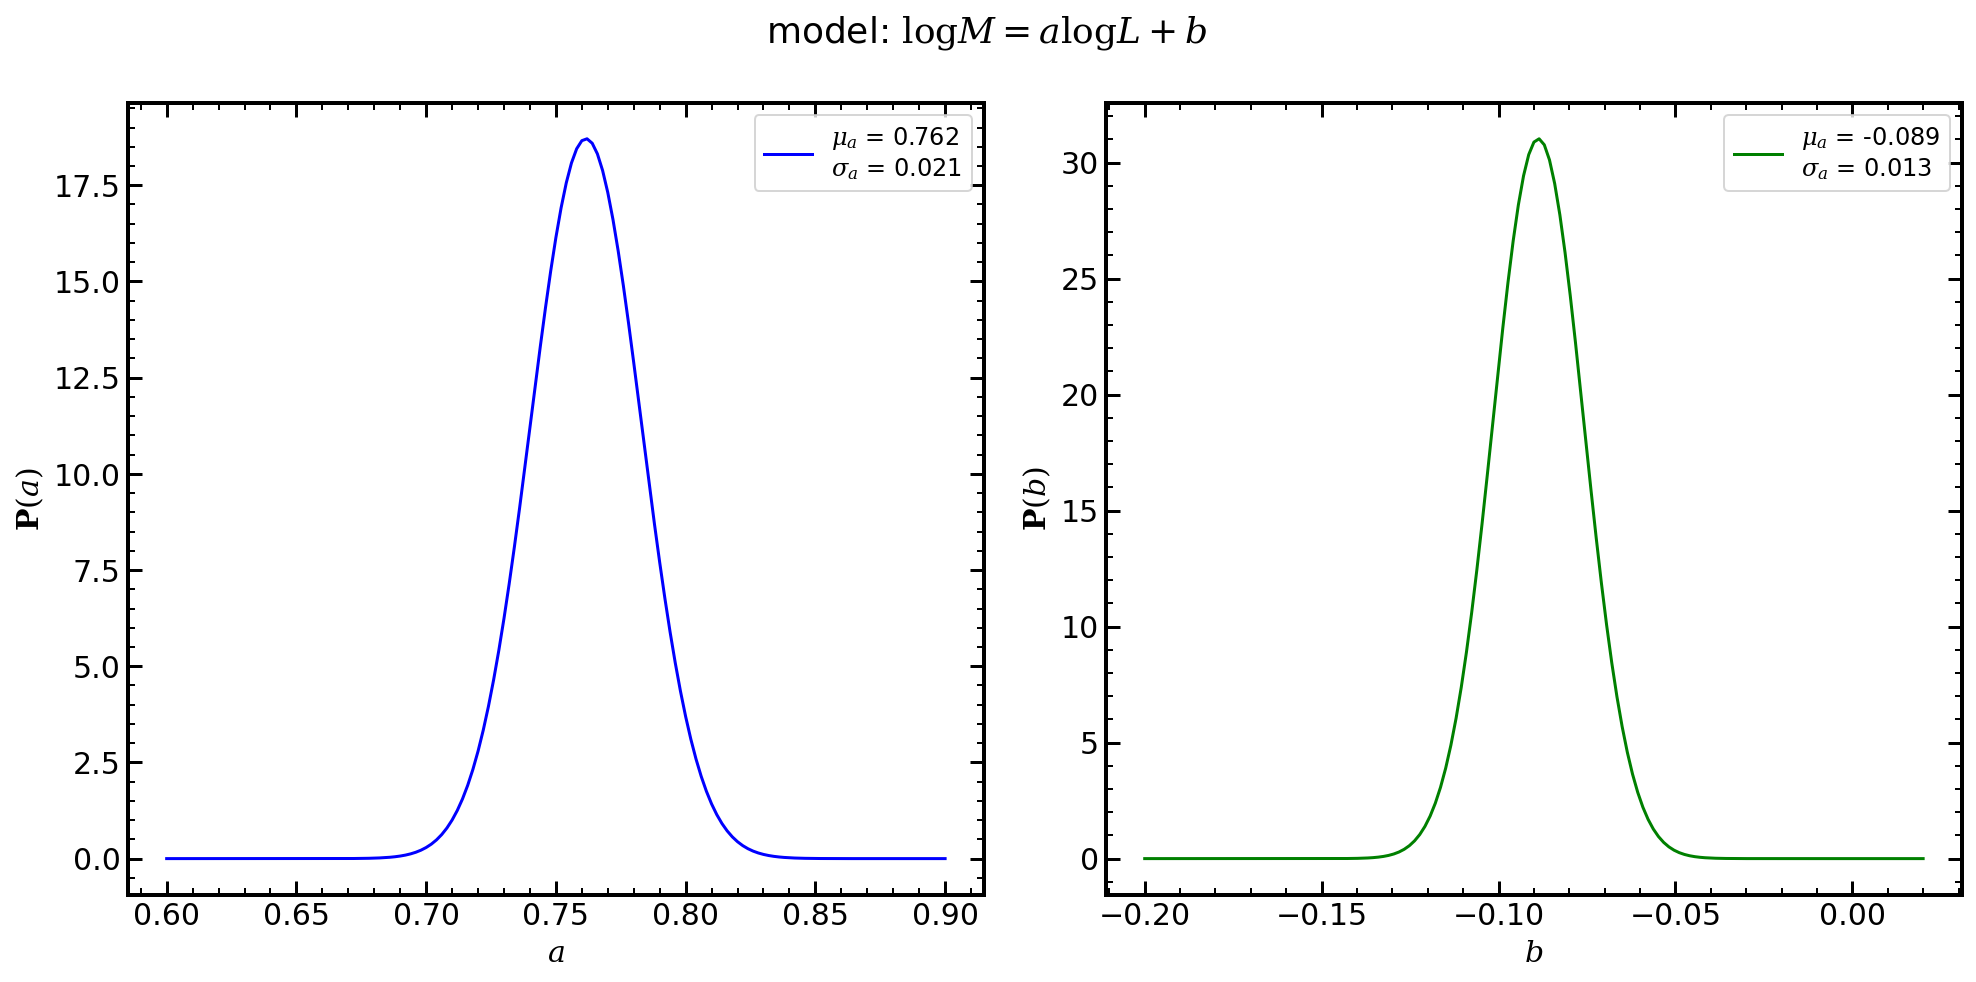

In [145]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

popt, pcov = curve_fit(gauss, a_space, prob_a1, p0=[0.75, 0.05])
print(popt)
print(pcov)

ax[0].plot(a_space, prob_a1, color='b', label=rf'$\mu_a$ = {popt[0]:.3f}{nl}$\sigma_a$ = {popt[1]:.3f}')
ax[0].set(xlabel=r'$a$', ylabel=r'$\mathbf{P}(a)$')
ax[0].legend()

popt, pcov = curve_fit(gauss, b_space1, prob_b1, p0=[-0.1, 0.03])
print(popt)
print(pcov)

ax[1].plot(b_space1, prob_b1, color='g', label=rf'$\mu_a$ = {popt[0]:.3f}{nl}$\sigma_a$ = {popt[1]:.3f}')
ax[1].set(xlabel=r'$b$', ylabel=r'$\mathbf{P}(b)$')
ax[1].legend()

plt.suptitle(r'model: $\log M = a\log L + b$')
plt.tight_layout()
plt.show()

[0.7615911  0.02132116]
[[ 3.80487243e-27 -1.01619335e-33]
 [-1.01619335e-33  2.53658172e-27]]
[0.15845077 0.01027729]
[[ 6.47179543e-31 -7.40358983e-38]
 [-7.40358983e-38  4.31453037e-31]]


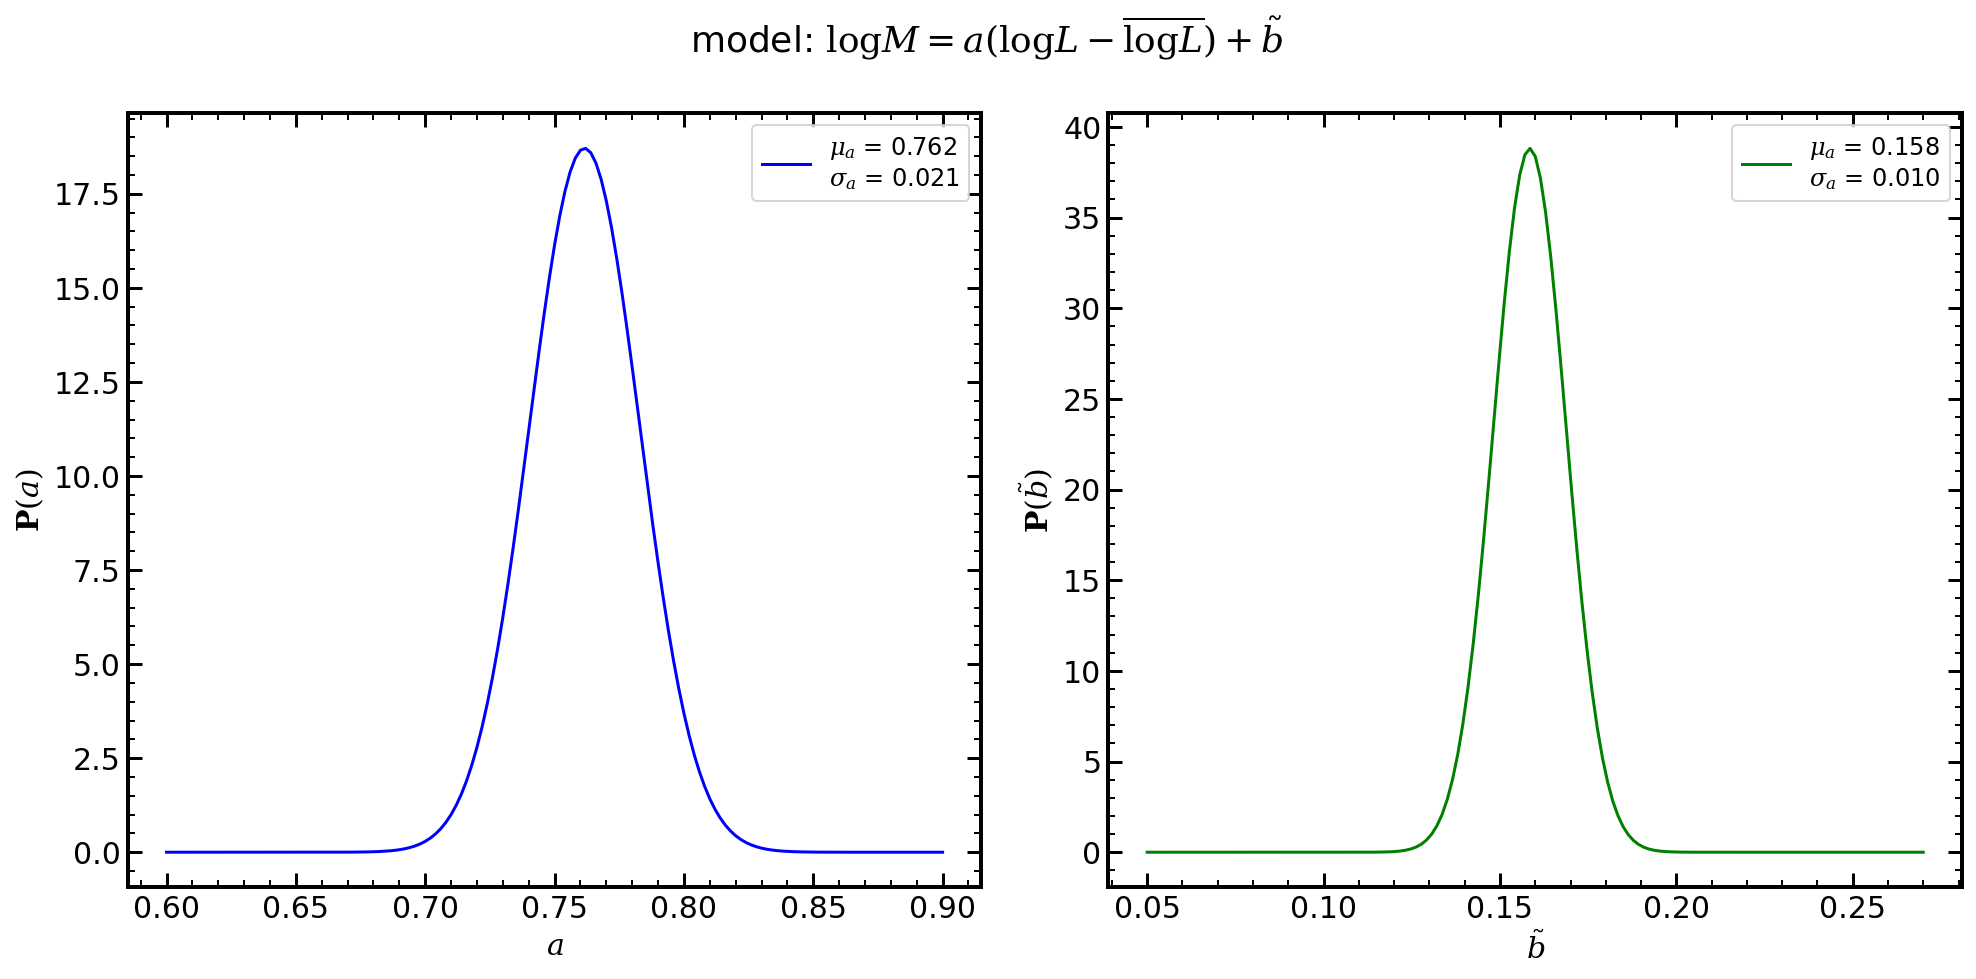

In [148]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

popt, pcov = curve_fit(gauss, a_space, prob_a2, p0=[0.75, 0.05])
print(popt)
print(pcov)

ax[0].plot(a_space, prob_a2, color='b', label=rf'$\mu_a$ = {popt[0]:.3f}{nl}$\sigma_a$ = {popt[1]:.3f}')
ax[0].set(xlabel=r'$a$', ylabel=r'$\mathbf{P}(a)$')
ax[0].legend()

popt, pcov = curve_fit(gauss, b_space2, prob_b2, p0=[0.15, 0.03])
print(popt)
print(pcov)

ax[1].plot(b_space2, prob_b2, color='g', label=rf'$\mu_a$ = {popt[0]:.3f}{nl}$\sigma_a$ = {popt[1]:.3f}')
ax[1].set(xlabel=r'$\tilde{b}$', ylabel=r'$\mathbf{P}(\tilde{b})$')
ax[1].legend()

plt.suptitle(r'model: $\log M = a(\log L - \overline{\log L}) + \tilde{b}$')
plt.tight_layout()
plt.show()

In [192]:
a_mc = np.random.normal(loc=0.762, scale=0.021, size=1000)
b_mc = np.random.normal(loc=0.158, scale=0.011, size=1000)

(1000, 2)


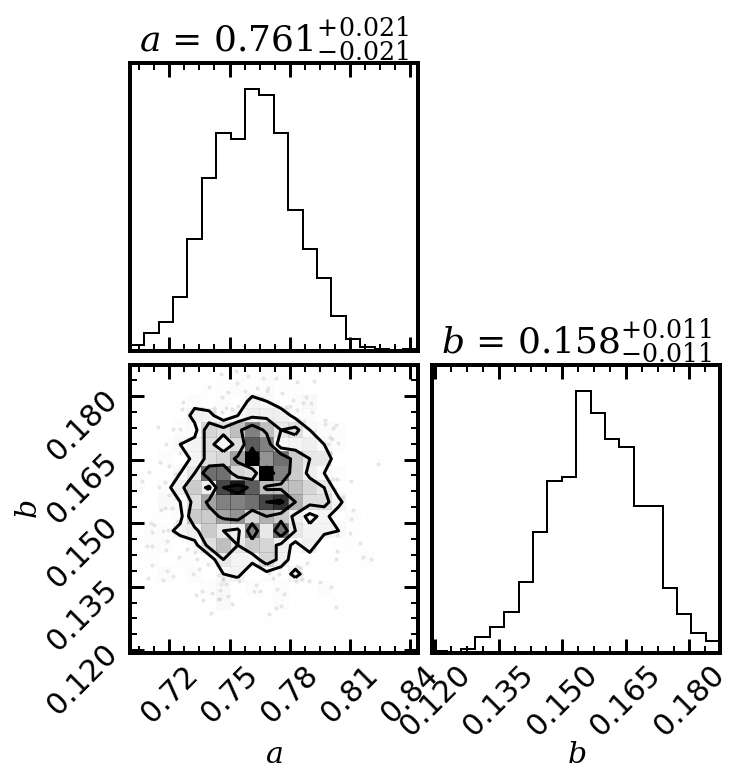

In [193]:
sample = [a_mc, b_mc]
sample = np.array(sample)
sample = sample.T
print(sample.shape)

figure = corner.corner(sample, labels=[r'$a$', r'$b$'], show_titles=True, title_fmt='.3f')

In [205]:
x[:].mean()

0.32458322809174395

In [207]:
fisher = np.zeros((2,2))
fisher[0,0] = sum([(xx-x.mean())**2/yyerr**2 for xx, yyerr in zip(x, yerr)])
fisher[1,1] = sum([1/yyerr**2 for yyerr in yerr])

In [211]:
fisher[0,0]**-0.5

0.02124758162412986

In [212]:
fisher[1,1]**-0.5

0.01024182131109136

In [170]:
def lnlike(theta, x, y, yerr):
    a, b = theta
    model = a * x + b
    return -0.5 * np.sum((y - model) ** 2 / yerr**2 )

def lnprior(theta):
    a, b = theta
    if abs(a - 0.75) < 1 and abs(b+0.1) < 1:
        return 0.0
    else:
        return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if lp is -np.inf:
        return -np.inf
    else:
        return lp + lnlike(theta, x, y, yerr) 

x = np.log10(df['L'])
y = np.log10(df['M'])
yerr = [merr/m/np.log(10) for merr, m in zip(df['M_err'], df['M'])]

pos = np.array([0.762, -0.089]) + 1e-2 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))

In [171]:
sampler.run_mcmc(pos, 1000, progress=True)

emcee: Exception while calling your likelihood function:
  params: [ 0.75870965 -0.1022134 ]
  args: (0     0.547775
1     0.753583
2     0.301030
3    -0.318759
4     0.579784
5    -0.408935
6     0.864511
7     1.173186
8     0.390935
9     0.732394
10   -0.309804
11   -0.026872
12    0.334454
13    0.680336
14    0.617000
15    0.806180
16    1.022841
17    0.195900
18    0.123852
19    1.128722
20    0.230449
21    0.394452
22    0.720159
23    0.071882
24   -0.221849
25    0.071882
26    0.658965
27    0.531479
28    0.716838
29    0.089905
30    0.235528
31    0.320146
32   -0.070581
33    0.599883
34    0.278754
35    0.687529
36    0.779596
37    0.107210
38    0.255273
39    0.530200
40    0.262451
41   -0.568636
42   -0.795880
43   -0.795880
44    0.328380
Name: L, dtype: float64, 0     0.089905
1     0.342423
2     0.348305
3    -0.356547
4     0.421604
5    -0.259637
6     0.705008
7     0.655138
8     0.136721
9     0.550228
10   -0.356547
11   -0.026872
12    0.303196
13 

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-167-1c44cfd6fa66>", line 3, in log_probability
    model = a * x + b
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 1936, in __array_ufunc__
    def empty(self) -> bool_t:
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py", line 250, in array_ufunc
    return result
  File "pandas/_libs/ops_dispatch.pyx", line 91, in pandas._libs.ops_dispatch.maybe_dispatch_ufunc_to_dunder_op
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/common.py", line 65, in new_method
    return NotImplemented
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py", line 109, in __rmul__
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 4998, in _arith_method
    2     True
  File "/opt/ana

TypeError: import_optional_dependency() got an unexpected keyword argument 'errors'

# Final term

In [6]:
!pwd

/Users/kangsoosang/Codes


## Problem 2

In [28]:
dirpath = '../Lectures/2021_fall_Statistics for Astrnomers/'
filename = 'galaxyspin_pair.txt'
filepath = dirpath + filename

f = open(filepath, 'r')
data = []

for line in lines:
    data.append([float(content) for content in line.split()])

f.close()
data = np.array(data)
df = pd.DataFrame(data, columns=['s1x', 's1y', 's1z', 's2x', 's2y', 's2z'])
print(df)
df.to_csv(dirpath+'galaxyspin_pair.csv', index=False)

            s1x       s1y       s1z       s2x       s2y       s2z
0     -0.989354 -0.084733  0.118313 -0.583437  0.075724 -0.808621
1     -0.989354 -0.084733  0.118313 -0.311823 -0.123239 -0.942114
2      0.117004 -0.896246 -0.427847 -0.583437  0.075724 -0.808621
3      0.117004 -0.896246 -0.427847 -0.311823 -0.123239 -0.942114
4     -0.471808 -0.441770  0.763044 -0.818717 -0.081883  0.568329
...         ...       ...       ...       ...       ...       ...
14175  0.413512 -0.809754 -0.416301 -0.304313 -0.185973 -0.934242
14176 -0.220687  0.975112 -0.021305 -0.708303 -0.667002  0.231116
14177 -0.220687  0.975112 -0.021305 -0.033066 -0.921290 -0.387469
14178  0.353455  0.758441 -0.547573 -0.708303 -0.667002  0.231116
14179  0.353455  0.758441 -0.547573 -0.033066 -0.921290 -0.387469

[14180 rows x 6 columns]


In [2]:
dirpath = '../Lectures/2021_fall_Statistics for Astrnomers/'
filename = 'galaxyspin_pair.csv'
filepath = dirpath + filename

df = pd.read_csv(filepath)

In [3]:
df

s1x       s1y       s1z       s2x       s2y       s2z
0     -0.989354 -0.084733  0.118313 -0.583437  0.075724 -0.808621
1     -0.989354 -0.084733  0.118313 -0.311823 -0.123239 -0.942114
2      0.117004 -0.896246 -0.427847 -0.583437  0.075724 -0.808621
3      0.117004 -0.896246 -0.427847 -0.311823 -0.123239 -0.942114
4     -0.471808 -0.441770  0.763044 -0.818717 -0.081883  0.568329
...         ...       ...       ...       ...       ...       ...
14175  0.413512 -0.809754 -0.416301 -0.304313 -0.185973 -0.934242
14176 -0.220687  0.975112 -0.021305 -0.708303 -0.667002  0.231116
14177 -0.220687  0.975112 -0.021305 -0.033066 -0.921290 -0.387469
14178  0.353455  0.758441 -0.547573 -0.708303 -0.667002  0.231116
14179  0.353455  0.758441 -0.547573 -0.033066 -0.921290 -0.387469

[14180 rows x 6 columns]

In [4]:
s1 = df[['s1x', 's1y', 's1z']].to_numpy()
s2 = df[['s2x', 's2y', 's2z']].to_numpy()
abscos = [abs(ss1@ss2) for ss1, ss2 in zip(s1, s2)]
abscos = np.array(abscos)
print(abscos.shape)

(14180,)


In [29]:
from random import choices

n_bootstrap = 1
n_data = len(s1)
resampled = []

for i in range(n_bootstrap):
    t1 = time()
    
    df_bootstrap = pd.DataFrame(df.values[np.random.randint(n_data, size=n_data)], columns=['s1x', 's1y', 's1z', 's2x', 's2y', 's2z'])
    s1 = df_bootstrap[['s1x', 's1y', 's1z']].to_numpy()
    s2 = df_bootstrap[['s2x', 's2y', 's2z']].to_numpy()
    abscos = [abs(ss1@ss2) for ss1, ss2 in zip(s1, s2)]
    abscos = np.array(abscos)
    
    resampled.append(np.histogram(abscos, bins=np.linspace(0,1,n_bins+1), density=True)[0])
    
    t2 = time()
    
print(t2-t1)

0.029356002807617188


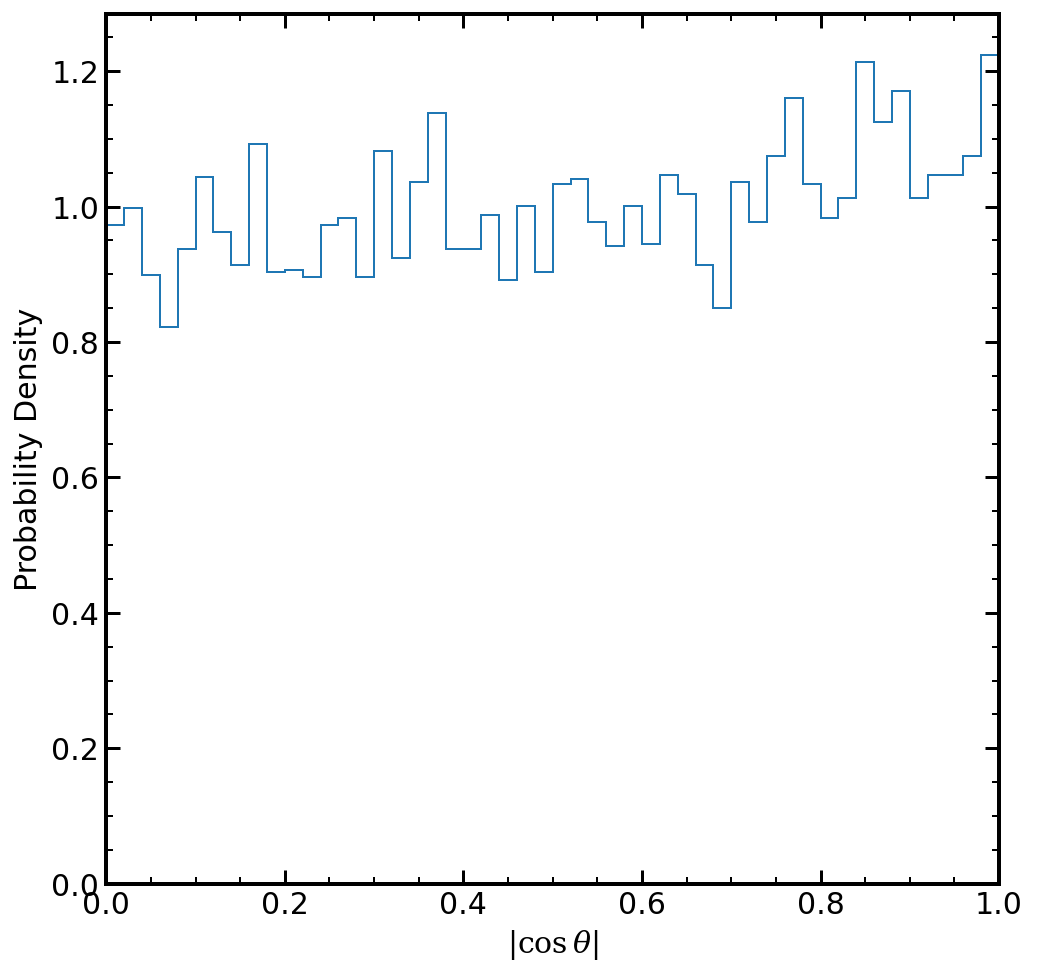

In [12]:
fig = plt.figure(figsize=(8,8))

n_bins = 50
hist_kwargs = {'bins':n_bins, 'histtype':'step', 'density':True}
plt.hist(abscos, **hist_kwargs)
plt.xlim(0,1)

plt.xlabel(r'$\|\cos\theta\|$')
plt.ylabel('Probability Density')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))

n_bins = 50
hist_kwargs = {'bins':n_bins, 'histtype':'step', 'density':True}
plt.hist(abscos, **hist_kwargs)
plt.xlim(0,1)

plt.xlabel(r'$\|\cos\theta\|$')
plt.ylabel('Probability Density')
plt.show()